# Logistic Regression
---
<b>Course: Independent Research Project (COM00151M)<b><br>
<b>Author: A.Krauskopf<b><br>
<b>Last Update: 4 August 2024<b>

This notebook includes the iterative experiment code and figure creation focusing on both non-differentially private and differentially private instances of the logistic regression classification method. It depends upon the .csv files referenced to reside in the Datasets subfolder in the same directory as this notebook. It also requires a Figures subfolder for the resulting imagery to be saved to.

<b>Package Prerequisites:<b>
- pandas
- numpy
- matplotlib
- joblib
- tqdm
- sklearn
- diffprivlib

<b>Other Notebooks:<b>
- Data Pre-Processing (IRP Data Pre-Processing.ipynb)
- Gaussian Naiive Bayes (IRP NB Final.ipynb)
- Random Forest (IRP RF Final.ipynb)

### 1: Setup

In [14]:
# Import necessary packages
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import diffprivlib as dp
import time

In [15]:
# Setup dataframe to hold timing statistics
lr_runtime = pd.DataFrame(columns=['Setup', 'Compare', 'Baseline', 'Smote'], index=['Start Time', 'End Time', 'Runtime'])

# Capture start time
lr_runtime.loc['Start Time', 'Setup'] = time.time()

In [16]:
# Open and read the data into a dataframe
train = pd.read_csv('Datasets/fraudTrain_clean.csv', index_col=0)
test = pd.read_csv('Datasets/fraudTest_clean.csv', index_col=0)

# Split into dependent and independent variables
X_train = train.drop(['is_fraud'], axis=1)
y_train = train['is_fraud']

X_test = test.drop(['is_fraud'], axis=1)
y_test = test['is_fraud']

In [17]:
# Additional requirements specific to DP-LR

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calculate the maximum L2 norm to prevent an error with DP-LR
total = pd.concat([train, test], ignore_index=True, sort=False)
X = total.drop(['is_fraud'], axis=1).values
X_scaled = scaler.fit_transform(X)
l2_norms = np.linalg.norm(X_scaled, axis=1)
data_norm = np.max(l2_norms)

lr_runtime.loc['End Time', 'Setup'] = time.time()

### 2: Compare non-private to DP(ε =∞)

In [18]:
lr_runtime.loc['Start Time', 'Compare'] = time.time()

# Compare the baseline non-DP to DP @ infinity value
num_runs = 30
lr_noDP_mcc_list = []
lr_DP_mcc_list = []

for run in tqdm(range(num_runs)):
    lr_noDP = LogisticRegression(solver='lbfgs', random_state=(42 + run), max_iter=150)
    lr_noDP.fit(X_train, y_train)
    y_pred_lr_noDP = lr_noDP.predict(X_test)
    lr_noDP_mcc_list.append(matthews_corrcoef(y_test, y_pred_lr_noDP))

    lr_DP = dp.models.LogisticRegression(epsilon=np.inf, random_state=(42 + run), max_iter=150, data_norm=data_norm)
    lr_DP.fit(X_train, y_train)
    y_pred_lr_DP = lr_DP.predict(X_test)
    lr_DP_mcc_list.append(matthews_corrcoef(y_test, y_pred_lr_DP))

# Convert list to numpy arrays
lr_noDP_mcc_list = np.array(lr_noDP_mcc_list)
lr_DP_mcc_list = np.array(lr_DP_mcc_list)

print("noDP MCC: ", lr_noDP_mcc_list.mean())
print("DP(e=inf) MCC: ", lr_DP_mcc_list.mean())

# Takeaway: noDPlr = DPlr @ e = infinity

lr_runtime.loc['End Time', 'Compare'] = time.time()

100%|█████████████████████████████████████████| 30/30 [00:37<00:00,  1.26s/it]

noDP MCC:  0.9981262439347174
DP(e=inf) MCC:  0.9981262439347174


### 3: Baseline DP and Privacy-Utility Trade-Off 

In [19]:
lr_runtime.loc['Start Time', 'Baseline'] = time.time()

# Define the data for the first graph

# Define the range of epsilon values including infinity
epsilons = np.logspace(4, 8, 50)
epsilons = np.append(epsilons, np.inf)
num_runs = 30

DPlr_mcc_rows = []

for run in tqdm(range(num_runs)):
    for epsilon in epsilons:
        DPlr = dp.models.LogisticRegression(epsilon=epsilon, random_state=(42 + run), max_iter=150, data_norm=data_norm)
        DPlr.fit(X_train, y_train)
        y_pred_DPlr = DPlr.predict(X_test)
        DPlr_mcc_rows.append(
            {
                "epsilon": epsilon,
                "run": run,
                "mcc": matthews_corrcoef(y_test, y_pred_DPlr),
            }
        )

# Convert data to dataframe and average across all runs
DPlr_mcc_df = pd.DataFrame(DPlr_mcc_rows).set_index("epsilon")
grouped_mcc = DPlr_mcc_df.groupby("epsilon")["mcc"].mean()

# Separate the non-private MCC values (epsilon = infinity)
avg_lr_noDP_mcc = grouped_mcc[np.inf]
avg_DPlr_mcc = grouped_mcc.iloc[:-1]

100%|█████████████████████████████████████████| 30/30 [32:26<00:00, 64.88s/it]


In [20]:
avg_DPlr_mcc

epsilon
1.000000e+04    0.038322
1.206793e+04    0.044440
1.456348e+04    0.051736
1.757511e+04    0.060321
2.120951e+04    0.070419
2.559548e+04    0.096271
3.088844e+04    0.115709
3.727594e+04    0.134773
4.498433e+04    0.155317
5.428675e+04    0.179016
6.551286e+04    0.203605
7.906043e+04    0.229133
9.540955e+04    0.254523
1.151395e+05    0.292829
1.389495e+05    0.328019
1.676833e+05    0.375383
2.023590e+05    0.430582
2.442053e+05    0.501671
2.947052e+05    0.569781
3.556480e+05    0.647378
4.291934e+05    0.703263
5.179475e+05    0.744815
6.250552e+05    0.788864
7.543120e+05    0.821112
9.102982e+05    0.848305
1.098541e+06    0.870299
1.325711e+06    0.889109
1.599859e+06    0.904599
1.930698e+06    0.918356
2.329952e+06    0.931711
2.811769e+06    0.942492
3.393222e+06    0.949619
4.094915e+06    0.958368
4.941713e+06    0.964679
5.963623e+06    0.971773
7.196857e+06    0.977758
8.685114e+06    0.983406
1.048113e+07    0.987234
1.264855e+07    0.990399
1.526418e+07    0

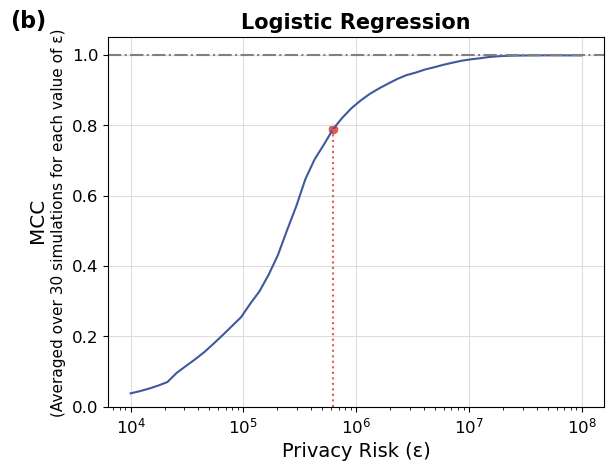

In [80]:
# Create the figure with the specified size
fig_lr1 = plt.figure(figsize=(6.4, 4.8))

# Plot the results
plt.semilogx(epsilons[:-1], avg_DPlr_mcc, color='#40589F', label="Differentially Private") # :-1 when infinity is included
plt.axhline(y=lr_noDP_mcc_list.mean(), color='grey', linestyle='-.', label="Non-Private")

# Define the optimal point
optimal = [625055.2, 0.788864]
plt.scatter(optimal[0], optimal[1], color ='#EB594D', marker = "o", label="Privacy-utility trade-off point")
plt.plot([optimal[0], optimal[0]], [0, optimal[1]], linestyle=':', color='#EB594D', label=r'$\epsilon_{optimal}$')
plt.ylim(0, 1.05)

plt.title("Logistic Regression", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=11)
fig_lr1.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a separate text elements
plt.figtext(0, 0.9, "(b)", ha="center", fontsize=16, fontweight='bold')

# Save and show the plot
plt.savefig('Figures/LR-Graph1.png', dpi=400, bbox_inches='tight')
plt.show()

lr_runtime.loc['End Time', 'Baseline'] = time.time()

### 4: The Impact of SMOTE

In [22]:
lr_runtime.loc['Start Time', 'Smote'] = time.time()

# Define data files and parameters
SMOTEtrain = ['fraudTrain_50.csv', 'fraudTrain_100.csv', 'fraudTrain_200.csv', 'fraudTrain_300.csv', 
              'fraudTrain_500.csv', 'fraudTrain_750.csv', 'fraudTrain_1000.csv', 'fraudTrain_2000.csv']
colNames = ['50_SMOTE', '100_SMOTE', '200_SMOTE', '300_SMOTE', 
            '500_SMOTE', '750_SMOTE', '1000_SMOTE', '2000_SMOTE']

epsilons = np.logspace(4, 8, 50)
epsilons = np.append(epsilons, np.inf)
num_runs = 30

# Dictionaries to store the resulting dataframes
avg_DPlr_SMOTE_mcc_dict = {}
avg_lr_noDP_SMOTE_mcc_dict = {}

# Loop through the training and test files
for file, name in tqdm(zip(SMOTEtrain, colNames), total=len(SMOTEtrain)):

    # Load the datasets
    SMOTE_data = pd.read_csv(f'Datasets/{file}')  # Test established previously
    X_train_SMOTE = SMOTE_data.drop(['is_fraud'], axis=1).values # not sure .values is needed
    y_train_SMOTE = SMOTE_data['is_fraud']

    # Scale to the existing schema
    X_train_SMOTE = scaler.transform(X_train_SMOTE)

    # Empty list for the loop to fill
    dplr_mcc_SMOTE_rows = []
    
    for run in tqdm(range(num_runs), desc=f"Runs for {name}"):
        for epsilon in epsilons:
            DPlr_SMOTE = dp.models.LogisticRegression(epsilon=epsilon, random_state=(42 + run), max_iter=150, data_norm=data_norm)
            DPlr_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)
            y_pred_DPlr_SMOTE = DPlr_SMOTE.predict(X_test) # Test established previously
            dplr_mcc_SMOTE_rows.append( 
                {
                    "epsilon": epsilon,
                    "run": run,
                    "mcc": matthews_corrcoef(y_test, y_pred_DPlr_SMOTE), 
                } 
            ) # Test established previously

    # Convert data to dataframe
    dplr_mcc_SMOTE_df = pd.DataFrame(dplr_mcc_SMOTE_rows)
    #dplr_mcc_SMOTE_df = pd.DataFrame(dplr_mcc_SMOTE_rows).set_index("epsilon")

    # Compute the average MCC across all runs
    grouped_mcc_SMOTE = dplr_mcc_SMOTE_df.groupby("epsilon")["mcc"].mean()

    # Separate the non-private MCC value (epsilon = infinity)
    avg_lr_noDP_SMOTE_mcc = grouped_mcc_SMOTE[np.inf]
    avg_DPlr_SMOTE_mcc = grouped_mcc_SMOTE.iloc[:-1]
   
    # Store the resulting dataframe in the dictionary
    avg_lr_noDP_SMOTE_mcc_dict[name] = avg_lr_noDP_SMOTE_mcc
    avg_DPlr_SMOTE_mcc_dict[name] = avg_DPlr_SMOTE_mcc

# Access the resulting dataframes using avg_DPlr_mcc_dict
print('Complete')

100%|███████████████████████████████████████| 8/8 [4:01:13<00:00, 1809.17s/it]

Complete


In [23]:
# Add previously calculated baseline runs to the dictionaries
avg_lr_noDP_SMOTE_mcc_dict['Baseline'] = lr_noDP_mcc_list.mean()
avg_DPlr_SMOTE_mcc_dict['Baseline'] = avg_DPlr_mcc

print(avg_lr_noDP_SMOTE_mcc_dict)
print(avg_DPlr_SMOTE_mcc_dict)

{'50_SMOTE': 0.9983606528001234, '100_SMOTE': 0.9983606528001234, '200_SMOTE': 0.9983606528001234, '300_SMOTE': 0.9995318852157019, '500_SMOTE': 0.9995318852157019, '750_SMOTE': 0.9995318852157019, '1000_SMOTE': 0.9995318852157019, '2000_SMOTE': 0.9995318852157019, 'Baseline': 0.9981262439347174}
{'50_SMOTE': epsilon
1.000000e+04    0.042967
1.206793e+04    0.050653
1.456348e+04    0.059899
1.757511e+04    0.082967
2.120951e+04    0.100356
2.559548e+04    0.116883
3.088844e+04    0.135847
3.727594e+04    0.156863
4.498433e+04    0.178118
5.428675e+04    0.200302
6.551286e+04    0.223298
7.906043e+04    0.257801
9.540955e+04    0.294713
1.151395e+05    0.338754
1.389495e+05    0.397072
1.676833e+05    0.467497
2.023590e+05    0.538113
2.442053e+05    0.613629
2.947052e+05    0.670752
3.556480e+05    0.715502
4.291934e+05    0.762507
5.179475e+05    0.799929
6.250552e+05    0.830245
7.543120e+05    0.857082
9.102982e+05    0.879737
1.098541e+06    0.895667
1.325711e+06    0.910321
1.5998

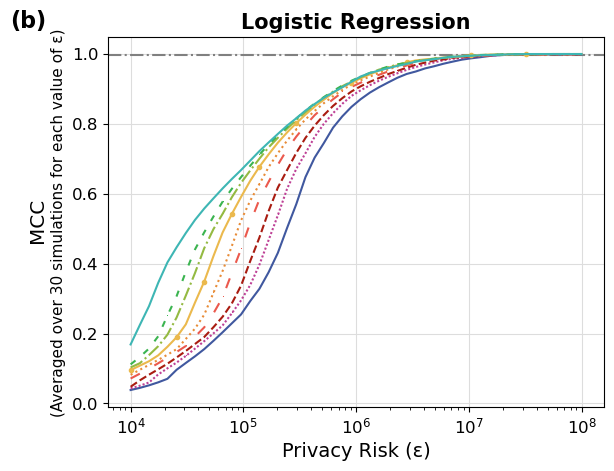

In [85]:
# Create the figure with the specified size
fig_lr2 = plt.figure(figsize=(6.4, 4.8))

# Plot the non-DP smote values
plt.axhline(y=avg_lr_noDP_SMOTE_mcc_dict['Baseline'], color='grey', linestyle='-.', label="Non-DP Baseline")

lr_MCC_min = min(avg_lr_noDP_SMOTE_mcc_dict.values())
lr_MCC_max = max(avg_lr_noDP_SMOTE_mcc_dict.values())
plt.axhspan(lr_MCC_max, lr_MCC_min, facecolor='silver', alpha=0.2, label="Non-Private SMOTE Range")

plt.semilogx(epsilons[:-1], avg_DPlr_SMOTE_mcc_dict['Baseline'], color='#40589F', label="Baseline")

# Add the SMOTE lines for comparison
colors = ['#BE4196', '#A91C11', '#EB594D', '#E88C38', '#EBB94D', '#94BA42', '#3BB450', '#3EB6B4']
labels = ['50% SMOTE', '100% SMOTE', '200% SMOTE', '300% SMOTE', '500% SMOTE', '750% SMOTE', '1000% SMOTE', '2000% SMOTE']
widths = [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5 ]
styles = [(0, (1, 1)), '--', (0, (5, 8)), ':', '-', '-.', (0, (3, 5)), '-' ]
markers= [",", ",", ",", ",", ".", ",", ",", ","] 

for name, color, label, width, style, marker in zip(colNames[:], colors, labels, widths, styles, markers):
    plt.semilogx(epsilons[:-1], avg_DPlr_SMOTE_mcc_dict[name], color=color, label=label, linewidth=width, 
                 linestyle=style, marker=marker, markevery=.1)

plt.title("Logistic Regression", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=11)
fig_lr2.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a separate text elements
plt.figtext(0, 0.9, "(b)", ha="center", fontsize=16, fontweight='bold')

# Save and show the plot
plt.savefig('Figures/LR-Graph2.png', dpi=600, bbox_inches='tight')
plt.show()

lr_runtime.loc['End Time', 'Smote'] = time.time()

In [25]:
# Calculate Runtimes
lr_runtime.loc['Runtime'] = lr_runtime.loc['End Time'] - lr_runtime.loc['Start Time']

# Output Runtime data
rf_runtime

,Setup,Compare,Baseline,Smote
Start Time,1721925699.875426,1721925701.036895,1721925739.009443,1721927686.010846
End Time,1721925701.03256,1721925738.973803,1721927686.006674,1721942159.997631
Runtime,1.157134,37.936908,1946.997231,14473.986785


In [33]:
print(lr_runtime.loc['Runtime'].sum())

16460.07805800438


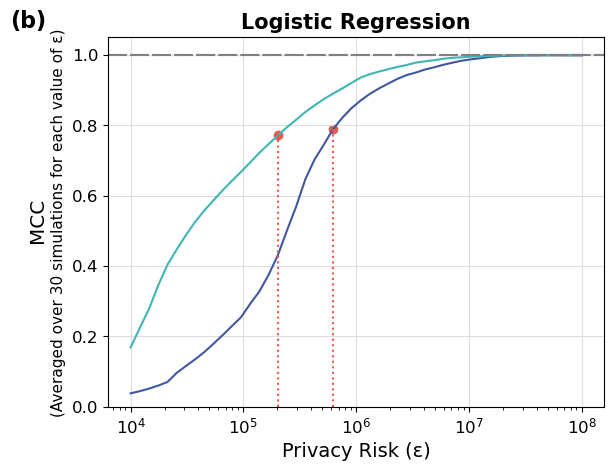

In [82]:
# Baseline to 2000_SMOTE comparison

# Create the figure with the specified size
fig_lr3 = plt.figure(figsize=(6.4, 4.8))

# Plot the results
plt.semilogx(epsilons[:-1], avg_DPlr_mcc, color='#40589F', label="Differentially Private") 
plt.semilogx(epsilons[:-1], avg_DPlr_SMOTE_mcc_dict['2000_SMOTE'], color='#3EB6B4', label="2000% SMOTE") 

# Use list comprehension to plot multiple horizontal lines
[plt.axhline(y=y, color=color, linestyle=style, label=label) for y, color, style, label in zip(
    [lr_noDP_mcc_list.mean(), avg_lr_noDP_SMOTE_mcc_dict['2000_SMOTE']],
    ['grey', 'grey'],
    ['-.', '--'],
    ["Non-Private Baseline", "Non-Private 2000% SMOTE"])
]

# Define the optimal epsilon point
#optimal = [625055.2, 0.788864] defined above
optimal_smote = [202359.0, 0.770881]

plt.scatter(optimal[0], optimal[1], color ='#EB594D', marker = "o", label='Privacy-utility trade-off point')
plt.scatter(optimal_smote[0], optimal_smote[1], color ='#EB594D', marker = "o")

plt.plot([optimal[0], optimal[0]], [0, optimal[1]], linestyle=':', color='#EB594D', label=r'$\epsilon_{optimal}$')
plt.plot([optimal_smote[0], optimal_smote[0]], [0, optimal_smote[1]], linestyle=':', color='#EB594D')
plt.ylim(0, 1.05)

plt.title("Logistic Regression", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=11)
fig_lr3.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a separate text elements
plt.figtext(0, 0.9, "(b)", ha="center", fontsize=16, fontweight='bold')

# Save and show the plot
plt.savefig('Figures/LR-Graph3.png', dpi=800, bbox_inches='tight') 
plt.show()